### Importing packages and data

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
df = pd.read_csv("BostonHousing.csv")

### Exploratory analysis

Median house price follows an approximate normal distribution
Median ($21.2k) and mean ($22.5k) are close, further evidence of normality
Some evidence of a second peak in median house price around $45k - $50k
No null values, all variables have a count of 506 observations


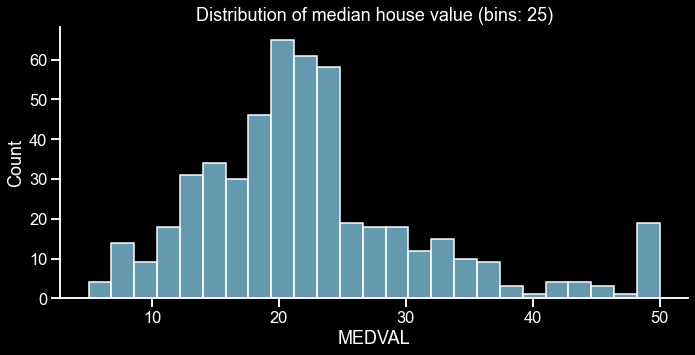

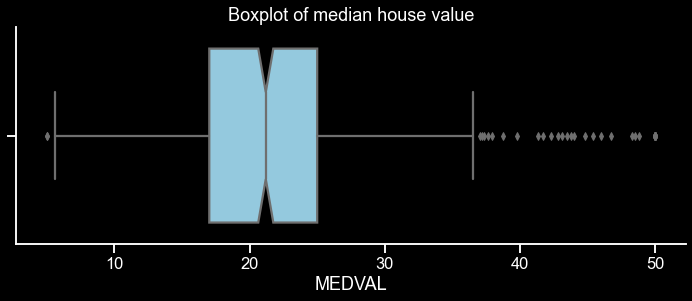

In [2]:
descriptives = df.describe()

print("Median house price follows an approximate normal distribution")
print("Median ($21.2k) and mean ($22.5k) are close, further evidence of normality")
print("Some evidence of a second peak in median house price around $45k - $50k")
print("No null values, all variables have a count of 506 observations")

nbins = 25
sns.displot(df["MEDVAL"], height = 5, aspect = 2, bins = nbins, color = "skyblue")
plt.title("Distribution of median house value (bins: {})".format(nbins))
plt.show()

plt.figure(figsize = (12,4))
ax = plt.subplot(111)
sns.boxplot(data = df, x = "MEDVAL", notch = True, color = "skyblue")
plt.title("Boxplot of median house value")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Exploring predictor relationships

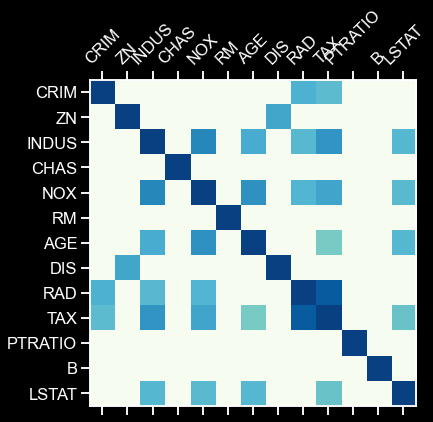

Evidence of multi-collinearity between some predictors
Strongest correlation between 'TAX' and 'RAD'



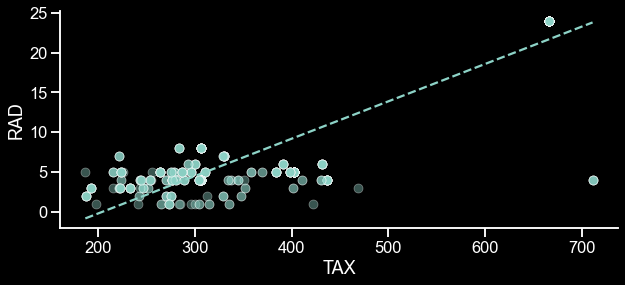

In [3]:
data = df.drop("MEDVAL", axis = 1).corr()
col_labels = data.columns
data = data.values
data = list(data.reshape(-1,1))
k = [0 if val < 0.5 else val[0] for val in data]
data = np.array(k).reshape(len(col_labels), len(col_labels))
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.matshow(data, cmap = "GnBu")
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(col_labels)))
ax.set_xticklabels(col_labels, rotation = 45)
ax.set_yticklabels(col_labels)
plt.show()

print("Evidence of multi-collinearity between some predictors")
print("Strongest correlation between 'TAX' and 'RAD'\n")

line_params = np.polyfit(df["TAX"],df["RAD"],1)
space = np.linspace(min(df["TAX"]), max(df["TAX"]), len(df["TAX"]))
line_fit = (space * line_params[0]) + line_params[1]

fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(111)
sns.scatterplot(data = df, x = "TAX", y = "RAD", alpha = 0.4)
plt.plot(space, line_fit, linestyle = "dashed")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

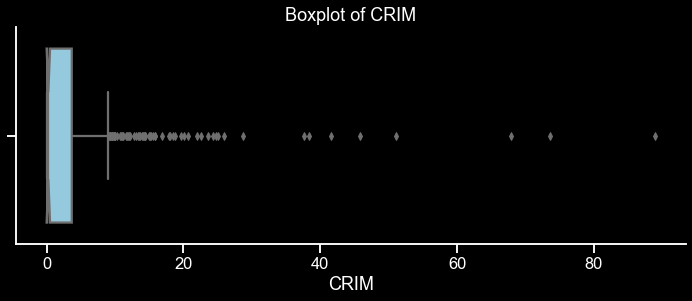

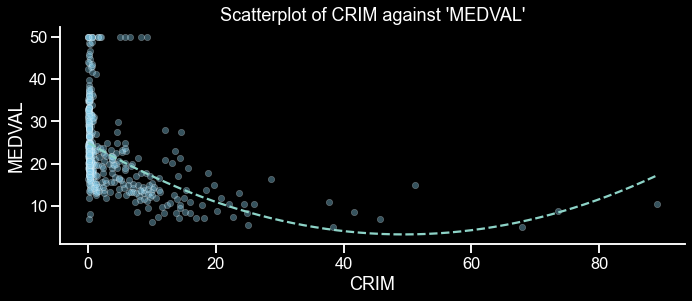

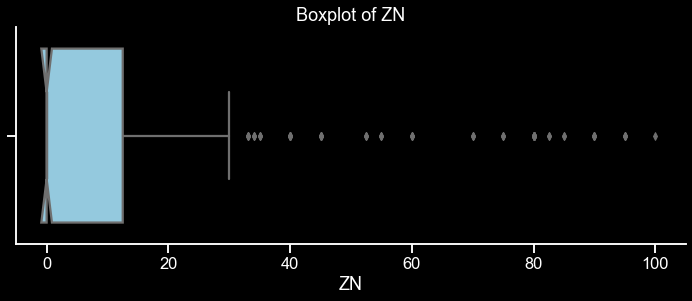

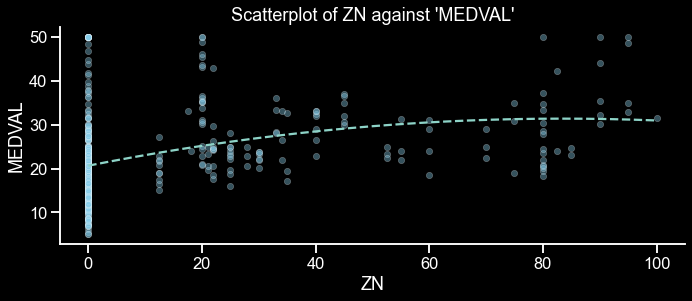

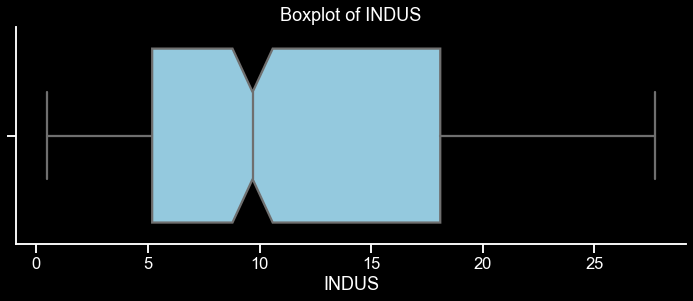

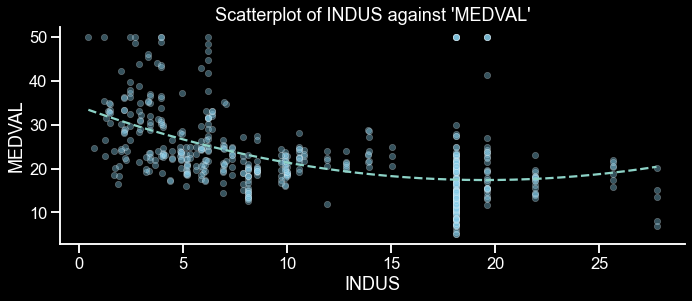

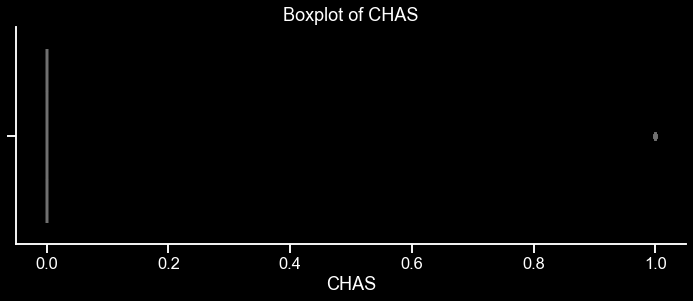

/Users/adamandrew/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


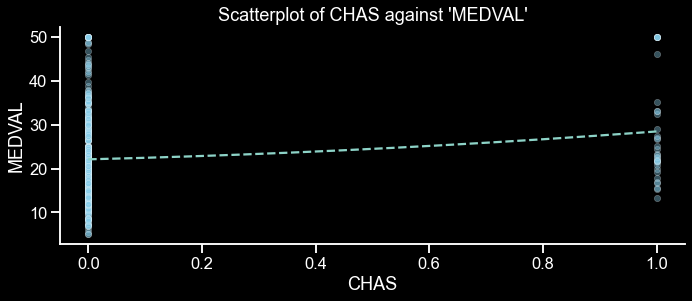

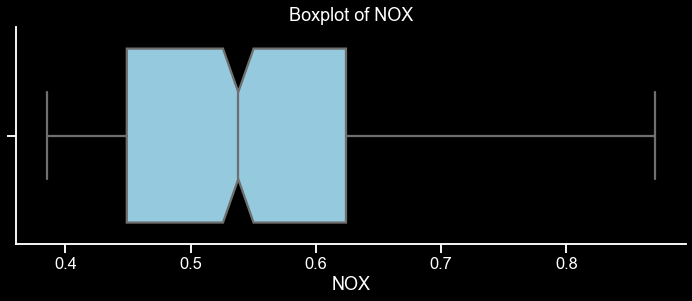

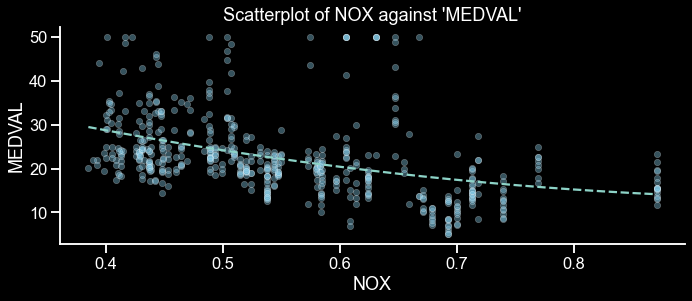

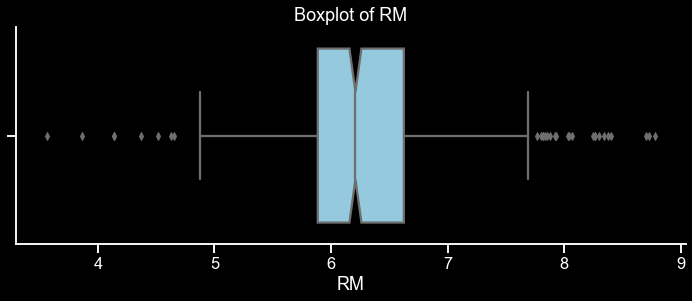

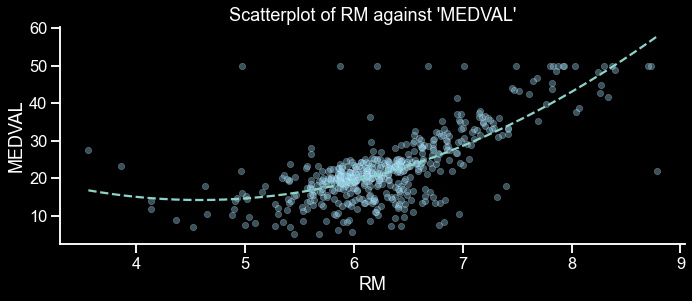

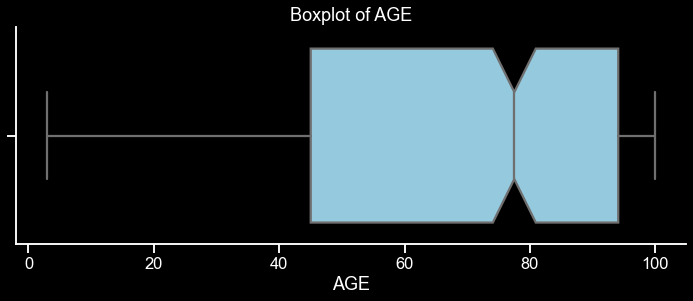

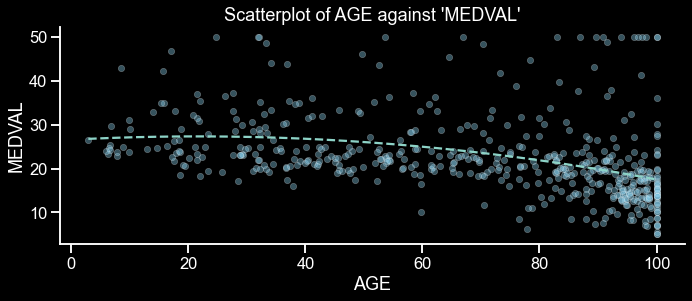

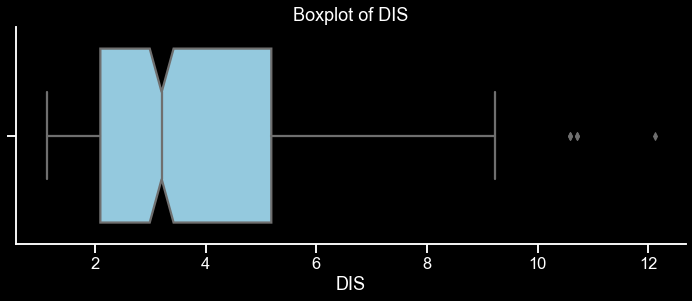

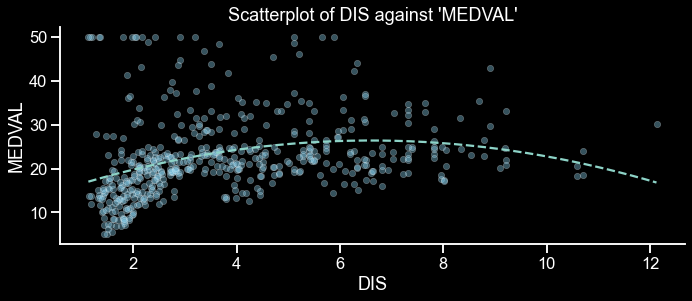

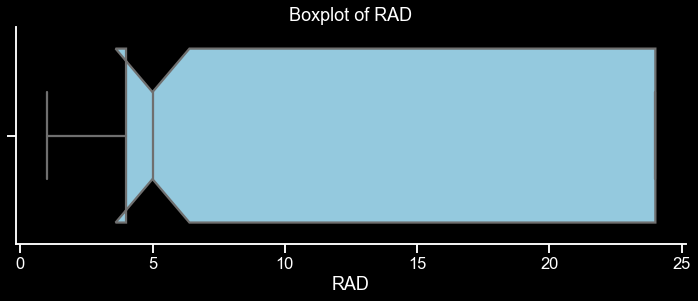

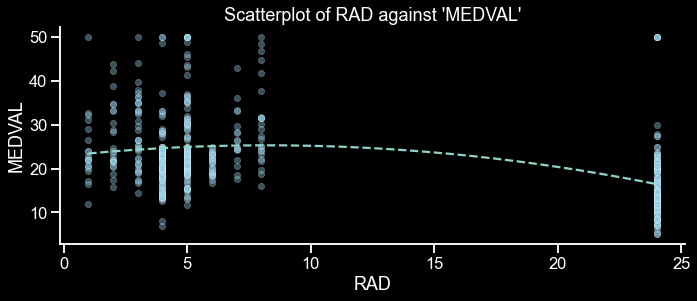

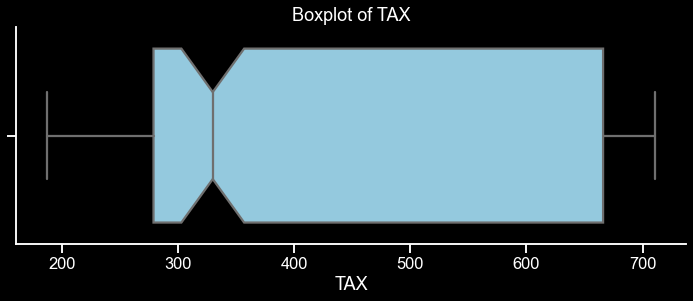

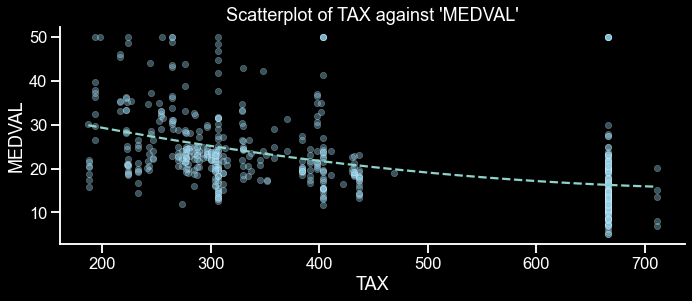

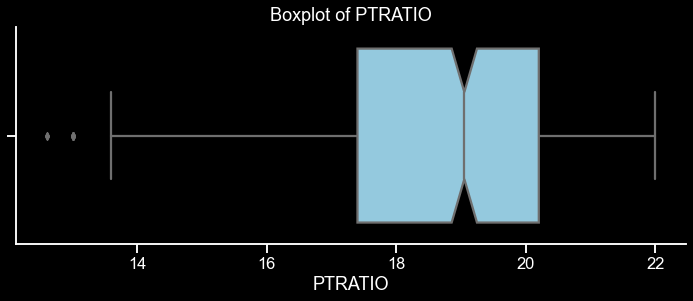

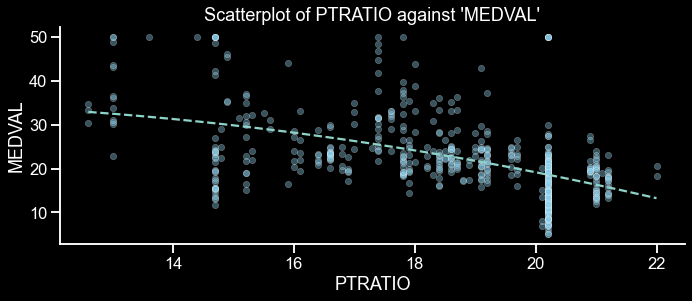

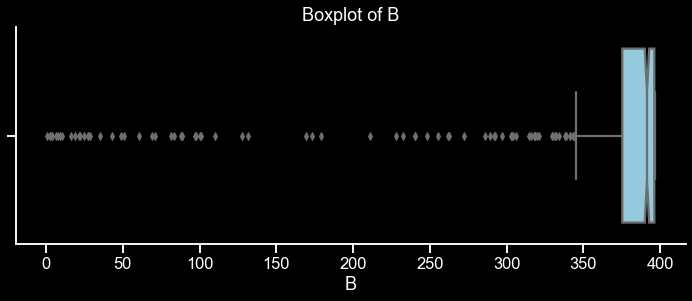

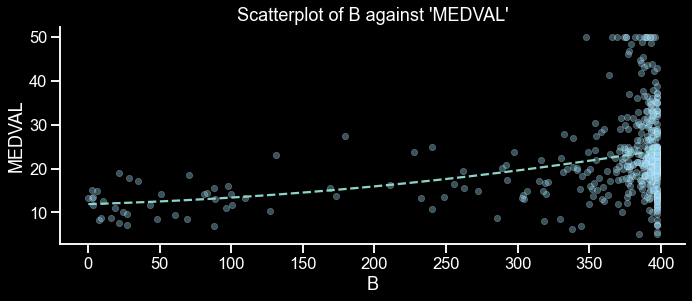

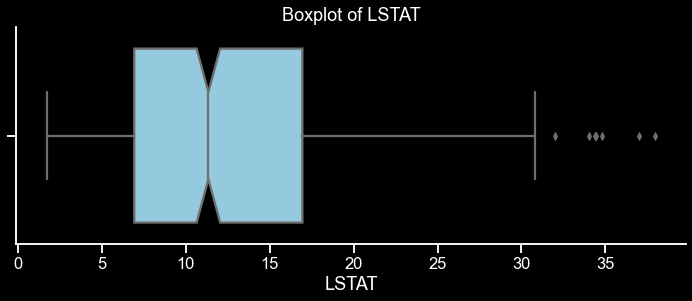

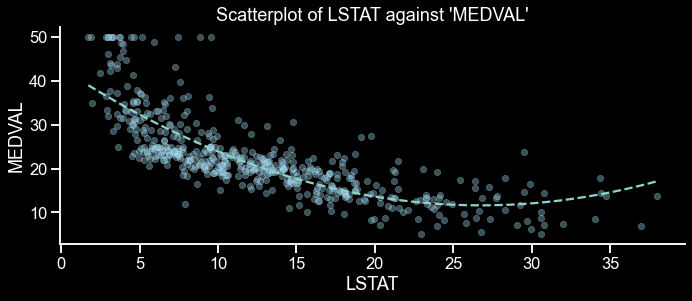

Findings from plotting each variable against the target 'MEDVAL':

CRIM  : Negative correlation against MEDVAL (with a large number of extreme low values)
CHAS  : Value '1' not associated with extreme high or lows in MEDVAL
NOX   : Evidence of a weak negative correlation with MEDVAL
RM    : Evidence of strong positive correlation with MEDVAL
LSTAT : Evidence of strong negative correlation with MEDVAL
B     : Skewed towards high values, evidence of weak negatuve correlation with MEDVAL


In [4]:
for col in df.columns[:-1]:
    
    print("\n")
    
    plt.figure(figsize = (12,4))
    ax = plt.subplot(111)
    sns.boxplot(data = df, x = col, notch = True, color = "skyblue")
    plt.title("Boxplot of {}".format(col))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    
    line_params = np.polyfit(df[col],df["MEDVAL"],2)
    space = np.linspace(min(df[col]), max(df[col]), len(df[col]))
    line_fit = (space**2*line_params[0]) + (space * line_params[1]) + line_params[2]
    
    plt.figure(figsize = (11.2,4))
    ax = plt.subplot(111)
    sns.scatterplot(data = df, x = col, y = "MEDVAL", color = "skyblue", s = 40, alpha = 0.4)
    plt.plot(space, line_fit, linestyle = "dashed")
    plt.title("Scatterplot of {} against 'MEDVAL'".format(col))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

print("Findings from plotting each variable against the target 'MEDVAL':\n")
print("CRIM  : Negative correlation against MEDVAL (with a large number of extreme low values)")
print("CHAS  : Value '1' not associated with extreme high or lows in MEDVAL")
print("NOX   : Evidence of a weak negative correlation with MEDVAL")
print("RM    : Evidence of strong positive correlation with MEDVAL")
print("LSTAT : Evidence of strong negative correlation with MEDVAL")
print("B     : Skewed towards high values, evidence of weak negatuve correlation with MEDVAL")


## Modeling preparation

In [6]:
X = df.drop("MEDVAL", axis = 1)
y = df["MEDVAL"]
X_train, X_test, y_train, y_test = tts(X, y, random_state = 42)

print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))
print("X test shape:  {}".format(X_test.shape))
print("y test shape:  {}".format(y_test.shape))

X train shape: (379, 13)
y train shape: (379,)
X test shape:  (127, 13)
y test shape:  (127,)


## Baseline modeling (Random Forest Regressor)

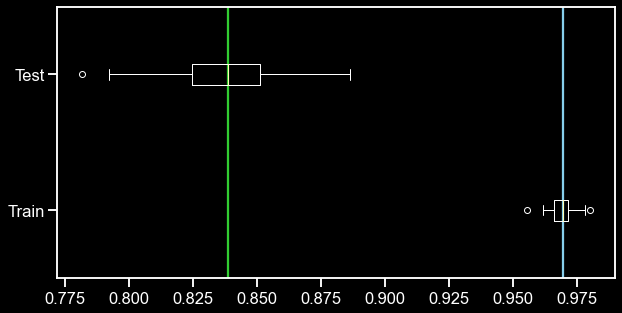


Mean train score: 0.97 much higher than mean test score: 0.84
Evidence of overfitting


In [80]:
train_scores = []
test_scores = []

for i in range(100):
    rfr = RandomForestRegressor(n_estimators = 10)
    rfr.fit(X_train, y_train)
    train_scores.append(rfr.score(X_train, y_train))
    test_scores.append(rfr.score(X_test, y_test))

data = pd.DataFrame({"Train": train_scores, "Test": test_scores})
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.boxplot(data.values, vert = False)
ax.vlines(np.median(train_scores), ymin = 0.5, ymax = 2.5, color = "skyblue")
ax.vlines(np.median(test_scores), ymin = 0.5, ymax = 2.5, color = "limegreen")
ax.set_yticklabels(["Train", "Test"])
plt.show()

baseline_train = np.mean(train_scores)
baseline_test = np.mean(test_scores)

print("\nMean train score: {:.2f} much higher than mean test score: {:.2f}\nEvidence of overfitting".format(
    np.mean(train_scores), np.mean(test_scores)))

## Improved model (GBR with tuning)

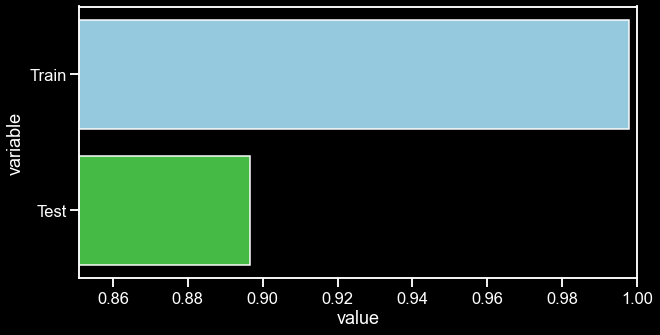

In [82]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures

mod = GradientBoostingRegressor(max_depth = 3, n_estimators = 400,
                                loss = "ls", learning_rate = 0.1,
                                min_samples_leaf = 3)
mod.fit(X_train, y_train)
data = pd.DataFrame({"Train_score": [mod.score(X_train, y_train)],
                     "Test_score":  [mod.score(X_test, y_test)]
                    }).melt()
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
sns.barplot(data = data, x = "value", y = "variable",
            palette = ["skyblue", "limegreen"], ax = ax)
ax.set(xlim = (min([train_score, test_score])*0.95, 1))
ax.set_yticklabels(["Train", "Test"])
plt.show()

pickle.dump(mod, open("BestModel.pkl", 'wb'))

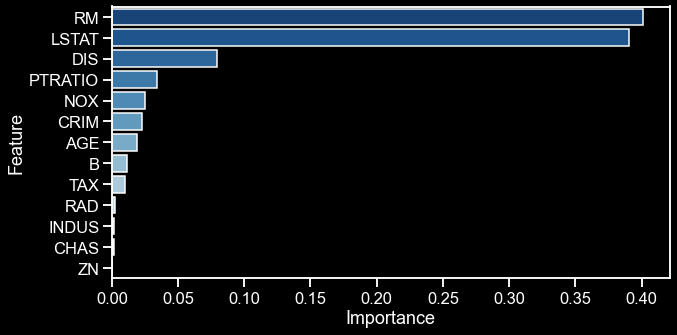

In [109]:
explainability = pd.DataFrame({
    "Feature"   : X_train.columns,
    "Importance": mod.feature_importances_
}).sort_values("Importance", ascending = False)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
sns.barplot(data = explainability, x = "Importance", y = "Feature", ax = ax, palette = "Blues_r")
plt.show()

CRIM        :    34.02 (Above average)
ZN          :    20.45 (Above average)
INDUS       :    13.22 (Above average)
CHAS        :     8.05 (Above average)
NOX         :     9.04 (Above average)
RM          :     3.57 (Below average)
AGE         :    12.86 (Below average)
DIS         :    13.11 (Above average)
RAD         :    34.41 (Above average)
TAX         :     4.54 (Below average)
PTRATIO     :     5.12 (Below average)
B           :    12.73 (Below average)
LSTAT       :     2.88 (Below average)

Prediction  :    20.61 (Below average)


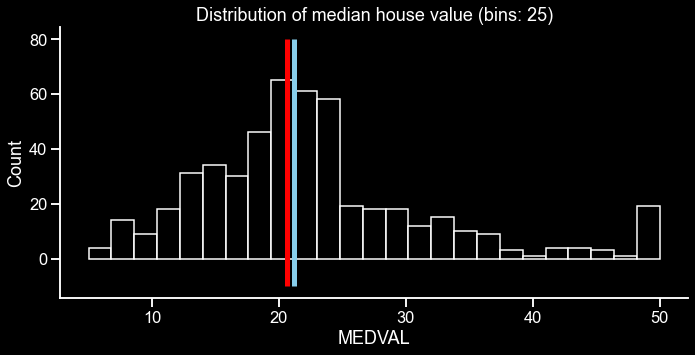

In [236]:
from pprint import pprint

X_new = pd.DataFrame(columns = X.columns)
med_y = np.median(y)
for col in X.columns:
    X_new[col] = [np.random.choice(X["LSTAT"])]
prediction = mod.predict(X_new.values)

for col in X_new.columns:
    med = np.median(X[col])
    print("{:<12}: {:>8} ({})".format(
        col, X_new.loc[0, col],
        "Above average" if X_new.loc[0, col] > med else "Below average"))
print("\n{:<12}: {:>8} ({})".format(
    "Prediction", np.round(prediction[0],2),
    "Above average" if prediction[0] > med_y else "Below average"))

nbins = 25
sns.displot(y, height = 5, aspect = 2, bins = nbins, color = "black")
plt.vlines(med_y, ymin = -10, ymax = 80, linewidth = 5, color = "skyblue")
plt.vlines(prediction, ymin = -10, ymax = 80, linewidth = 5,
           color = "limegreen" if prediction > med_y else "red")
plt.title("Distribution of median house value (bins: {})".format(nbins))
plt.show()

## __Evaluation__
---
##### 1 - Baseline model (RFR) achieved peak performance of around 0.84 on test set
##### 2 - Improved model (GBR) with some limited tuning achieved peak performance around 0.9
##### 3 - GridSearch for optimal parameters not used due to low number of observations available
##### 4 - Linear Regression achieved low performance, likely due to non-linear relationship between predictors and target as well as multicollinearity between some features
##### 5 - Adding polynomial features and interactions didn't help performance, wouldn't necessarily expect a large gain in performance in this way for a tree-based model but used as part of linear model testing
##### 6 - Predictors 'RM' and 'LSTAT' were most important to mode predictions (contribution as highest using gain method)
##### 7 - 'LSTAT' measures percentage of population with 'lower' status, negative correlation found in raw data, suggesting high percentage of 'lower' status is associated with lower median house value
##### 8 - 'RM' measures the number of rooms, positive correlation found in raw data, suggesting houses with more rooms are associated with higher median house value